# USS Queue Tolerance Prediction - Baseline Models Training & Evaluation

## Project Overview
This notebook implements baseline models for USS queue tolerance prediction using the engineered features from previous analysis. The focus is on handling imbalanced datasets and multi-task learning approach.

**Main Tasks:**
- Queue tolerance classification (3-class, imbalanced)
- Wait time threshold regression (continuous)
- Wait experience satisfaction (4-class)
- Time sensitivity classification (binary, highly imbalanced)

**Features:** 32D engineered features from sentiment, temporal, facility, user behavior, and time sensitivity analysis

## 1. Environment Setup and Data Loading

In [1]:
!pip install lightgbm xgboost catboost scikit-learn imbalanced-learn shap plotly seaborn -q

In [4]:
import os

# Ensure working from project root
current_dir = os.getcwd()
if current_dir.endswith('notebooks'):
    os.chdir('..')
    print("Adjusted working directory to project root")

Adjusted working directory to project root


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, 
    precision_recall_curve, f1_score, accuracy_score,
    mean_squared_error, mean_absolute_error, r2_score
)

# Imbalanced Learning
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline as ImbPipeline

# Models
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, Ridge

# Model Interpretation
import shap

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [6]:
# Load the processed dataset from feature engineering
data = pd.read_csv('data/processed/uss_features_labels.csv')

print(f"Dataset shape: {data.shape}")
print(f"\nColumn names:")
print(data.columns.tolist())

# Display basic information
print(f"\nMissing values:")
print(data.isnull().sum().sum())

Dataset shape: (5409, 43)

Column names:
['review_index', 'stars', 'name', 'review', 'publishedAtDate', 'visit_time', 'wait_time', 'tolerance_label', 'wait_threshold', 'wait_satisfaction', 'time_sensitivity', 'wait_queue_perception', 'wait_queue_management', 'wait_environment', 'facility_quality', 'technical_issues', 'safety_perception', 'staff_attitude', 'customer_service', 'express_value', 'overall_value', 'recommend_score', 'overall_satisfaction', 'weekday', 'weekend', 'holiday', 'wait_time_numeric', 'season_factor', 'rides_count', 'shows_count', 'other_count', 'avg_thrill_level', 'max_thrill_level', 'facility_diversity', 'express_usage', 'main_facility_popularity', 'review_length_norm', 'detailed_mention', 'complaint_intensity', 'positive_sentiment_ratio', 'group_interaction_indicator', 'holiday_pressure_factor', 'seasonal_mood_adjustment']

Missing values:
0


## 2. Data Exploration and Target Analysis

In [7]:
# Define feature columns and target columns
feature_columns = [
    # Fine-grained sentiment features (12D)
    'wait_queue_perception', 'wait_queue_management', 'wait_environment',
    'facility_quality', 'technical_issues', 'safety_perception',
    'staff_attitude', 'customer_service', 'express_value', 'overall_value',
    'recommend_score', 'overall_satisfaction',
    
    # Temporal-spatial features (5D)
    'weekday', 'weekend', 'holiday', 'wait_time_numeric', 'season_factor',
    
    # Facility characteristics (8D)
    'rides_count', 'shows_count', 'other_count', 'avg_thrill_level',
    'max_thrill_level', 'facility_diversity', 'express_usage', 'main_facility_popularity',
    
    # User behavior (5D)
    'review_length_norm', 'detailed_mention', 'complaint_intensity',
    'positive_sentiment_ratio', 'group_interaction_indicator',
    
    # Time sensitivity (2D)
    'holiday_pressure_factor', 'seasonal_mood_adjustment'
]

target_columns = {
    'tolerance_label': 'classification',  # Main task
    'wait_threshold': 'regression',       # Core regression task
    'wait_satisfaction': 'classification', # Auxiliary task
    'time_sensitivity': 'classification'   # Auxiliary task
}

print(f"Feature dimensions: {len(feature_columns)}D")
print(f"Number of prediction tasks: {len(target_columns)}")

Feature dimensions: 32D
Number of prediction tasks: 4


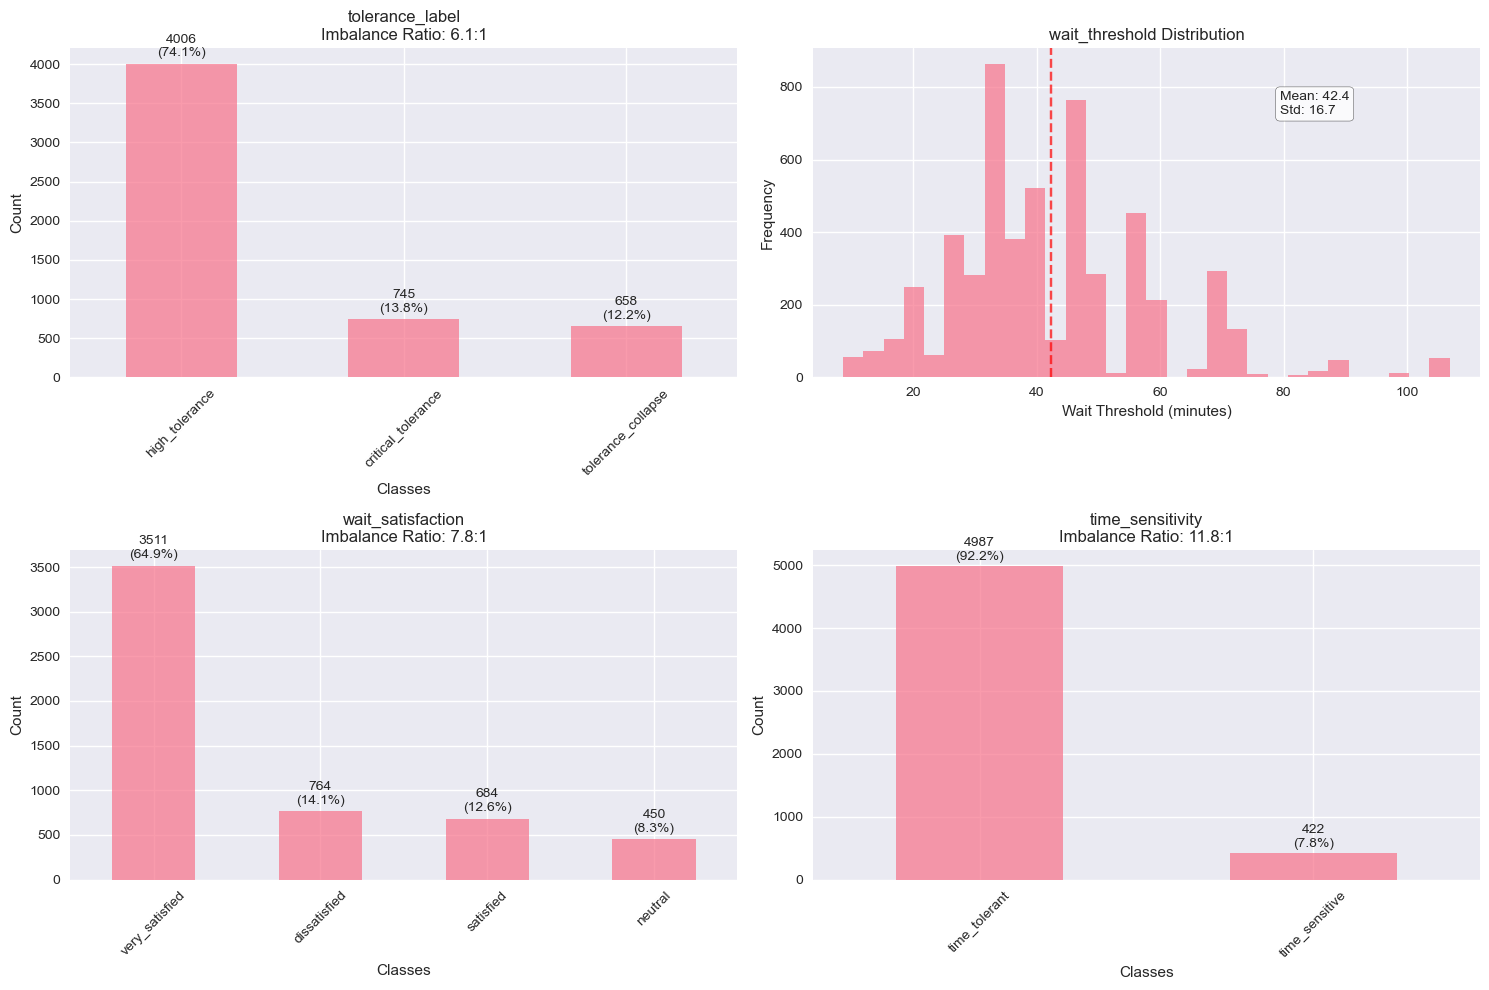


=== Target Variable Analysis ===

TOLERANCE_LABEL (classification):
tolerance_label
high_tolerance        4006
critical_tolerance     745
tolerance_collapse     658
Name: count, dtype: int64
Class proportions: tolerance_label
high_tolerance        0.741
critical_tolerance    0.138
tolerance_collapse    0.122
Name: proportion, dtype: float64

WAIT_THRESHOLD (regression):
Range: [8.6, 106.9]
Mean ± Std: 42.4 ± 16.7
Quartiles: [31.7, 39.6, 50.0]

WAIT_SATISFACTION (classification):
wait_satisfaction
very_satisfied    3511
dissatisfied       764
satisfied          684
neutral            450
Name: count, dtype: int64
Class proportions: wait_satisfaction
very_satisfied    0.649
dissatisfied      0.141
satisfied         0.126
neutral           0.083
Name: proportion, dtype: float64

TIME_SENSITIVITY (classification):
time_sensitivity
time_tolerant     4987
time_sensitive     422
Name: count, dtype: int64
Class proportions: time_sensitivity
time_tolerant     0.922
time_sensitive    0.078
Name

In [8]:
# Analyze target distributions and imbalance
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for i, (target, task_type) in enumerate(target_columns.items()):
    if task_type == 'classification':
        value_counts = data[target].value_counts()
        
        # Calculate imbalance ratio
        max_class = value_counts.max()
        min_class = value_counts.min()
        imbalance_ratio = max_class / min_class
        
        # Plot distribution
        value_counts.plot(kind='bar', ax=axes[i], alpha=0.7)
        axes[i].set_title(f'{target}\nImbalance Ratio: {imbalance_ratio:.1f}:1')
        axes[i].set_xlabel('Classes')
        axes[i].set_ylabel('Count')
        axes[i].tick_params(axis='x', rotation=45)
        
        # Add percentage labels
        total = value_counts.sum()
        for j, v in enumerate(value_counts.values):
            axes[i].text(j, v + total*0.01, f'{v}\n({v/total*100:.1f}%)', 
                        ha='center', va='bottom')
    
    else:  # regression
        data[target].hist(bins=30, ax=axes[i], alpha=0.7)
        axes[i].set_title(f'{target} Distribution')
        axes[i].set_xlabel('Wait Threshold (minutes)')
        axes[i].set_ylabel('Frequency')
        
        # Add statistics
        mean_val = data[target].mean()
        std_val = data[target].std()
        axes[i].axvline(mean_val, color='red', linestyle='--', alpha=0.7)
        axes[i].text(0.7, 0.8, f'Mean: {mean_val:.1f}\nStd: {std_val:.1f}', 
                    transform=axes[i].transAxes, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Print detailed statistics
print("\n=== Target Variable Analysis ===")
for target, task_type in target_columns.items():
    print(f"\n{target.upper()} ({task_type}):")
    if task_type == 'classification':
        print(data[target].value_counts())
        print(f"Class proportions: {data[target].value_counts(normalize=True).round(3)}")
    else:
        print(f"Range: [{data[target].min():.1f}, {data[target].max():.1f}]")
        print(f"Mean ± Std: {data[target].mean():.1f} ± {data[target].std():.1f}")
        print(f"Quartiles: {data[target].quantile([0.25, 0.5, 0.75]).round(1).tolist()}")

## 3. Feature Analysis and Correlation Study

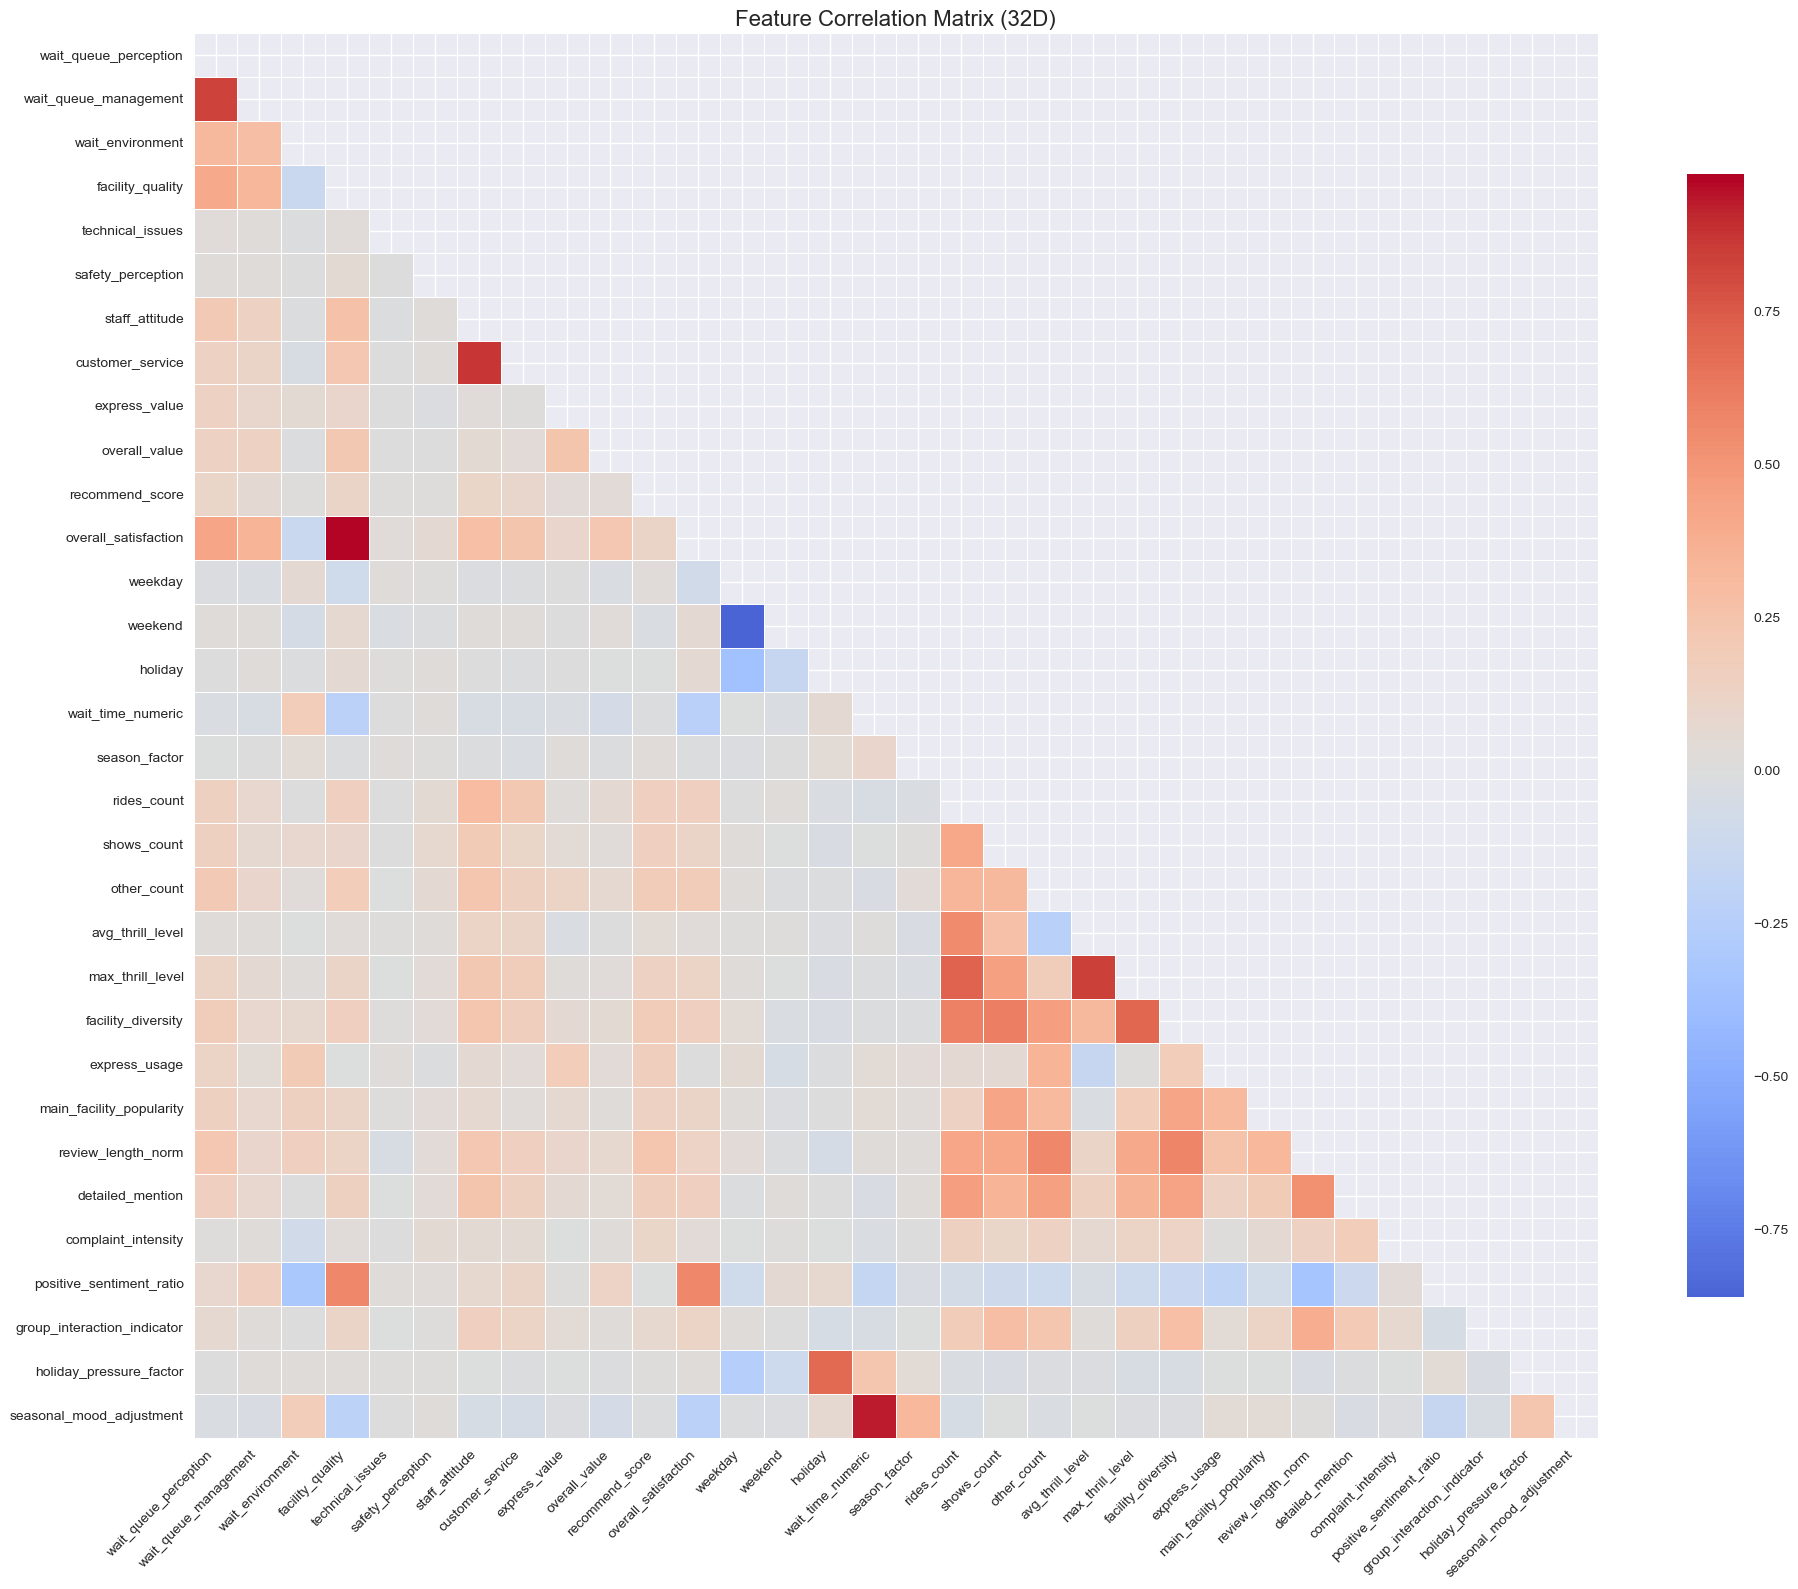


=== Highly Correlated Feature Pairs (|r| > 0.7) ===
wait_queue_perception <-> wait_queue_management: 0.823
facility_quality <-> overall_satisfaction: 0.973
staff_attitude <-> customer_service: 0.868
weekday <-> weekend: -0.863
wait_time_numeric <-> seasonal_mood_adjustment: 0.927
rides_count <-> max_thrill_level: 0.717
avg_thrill_level <-> max_thrill_level: 0.837


In [9]:
# Analyze feature correlations
feature_data = data[feature_columns]

# Feature correlation heatmap
plt.figure(figsize=(20, 16))
correlation_matrix = feature_data.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

sns.heatmap(correlation_matrix, mask=mask, annot=False, cmap='coolwarm', 
            center=0, square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Feature Correlation Matrix (32D)', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Identify highly correlated features
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:
            high_corr_pairs.append((
                correlation_matrix.columns[i], 
                correlation_matrix.columns[j], 
                correlation_matrix.iloc[i, j]
            ))

if high_corr_pairs:
    print("\n=== Highly Correlated Feature Pairs (|r| > 0.7) ===")
    for feat1, feat2, corr in high_corr_pairs:
        print(f"{feat1} <-> {feat2}: {corr:.3f}")
else:
    print("\n=== No highly correlated features found (threshold: 0.7) ===")

In [ ]:
# Feature distribution analysis by feature groups
feature_groups = {
    'Sentiment Features (12D)': feature_columns[:12],
    'Temporal Features (5D)': feature_columns[12:17],
    'Facility Features (8D)': feature_columns[17:25],
    'User Behavior (5D)': feature_columns[25:30],
    'Time Sensitivity (2D)': feature_columns[30:32]
}

fig, axes = plt.subplots(len(feature_groups), 1, figsize=(15, 20))

for i, (group_name, features) in enumerate(feature_groups.items()):
    # Calculate summary statistics for the group
    group_data = data[features]
    
    # Box plot for the feature group
    group_data.boxplot(ax=axes[i], rot=45)
    axes[i].set_title(f'{group_name} - Distribution Overview')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print feature statistics by group
print("\n=== Feature Group Statistics ===")
for group_name, features in feature_groups.items():
    print(f"\n{group_name}:")
    group_stats = data[features].describe()
    print(f"Mean range: [{group_stats.loc['mean'].min():.3f}, {group_stats.loc['mean'].max():.3f}]")
    print(f"Std range: [{group_stats.loc['std'].min():.3f}, {group_stats.loc['std'].max():.3f}]")
    print(f"Zero values: {(data[features] == 0).sum().sum()} / {len(data) * len(features)} features")

## 4. Data Preprocessing and Splitting

In [11]:
# Prepare features and targets
X = data[feature_columns].copy()
y_dict = {}

# Encode categorical targets
label_encoders = {}
for target, task_type in target_columns.items():
    if task_type == 'classification':
        le = LabelEncoder()
        y_dict[target] = le.fit_transform(data[target])
        label_encoders[target] = le
        print(f"{target} label mapping: {dict(zip(le.classes_, le.transform(le.classes_)))}")
    else:
        y_dict[target] = data[target].values

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=feature_columns, index=X.index)

print(f"\nFeature scaling completed. Shape: {X_scaled.shape}")
print(f"Scaled feature ranges:")
print(f"Min: {X_scaled.min().min():.3f}, Max: {X_scaled.max().max():.3f}")
print(f"Mean: {X_scaled.mean().mean():.3f}, Std: {X_scaled.std().mean():.3f}")

tolerance_label label mapping: {'critical_tolerance': np.int64(0), 'high_tolerance': np.int64(1), 'tolerance_collapse': np.int64(2)}
wait_satisfaction label mapping: {'dissatisfied': np.int64(0), 'neutral': np.int64(1), 'satisfied': np.int64(2), 'very_satisfied': np.int64(3)}
time_sensitivity label mapping: {'time_sensitive': np.int64(0), 'time_tolerant': np.int64(1)}

Feature scaling completed. Shape: (5409, 32)
Scaled feature ranges:
Min: -36.759, Max: 29.471
Mean: 0.000, Std: 1.000


In [12]:
# Create stratified train-test splits for each task
splits = {}
test_size = 0.2
random_state = 42

print("=== Creating Train-Test Splits ===")

# Use the main task (tolerance_label) for stratified splitting
main_target = 'tolerance_label'
X_train, X_test, y_main_train, y_main_test = train_test_split(
    X_scaled, y_dict[main_target], 
    test_size=test_size, 
    random_state=random_state, 
    stratify=y_dict[main_target]
)

# Use the same indices for all other tasks
train_idx = X_train.index
test_idx = X_test.index

splits['X_train'] = X_train
splits['X_test'] = X_test

for target in target_columns.keys():
    splits[f'y_{target}_train'] = y_dict[target][train_idx]
    splits[f'y_{target}_test'] = y_dict[target][test_idx]

print(f"Training set size: {len(X_train)} ({len(X_train)/len(X_scaled)*100:.1f}%)")
print(f"Test set size: {len(X_test)} ({len(X_test)/len(X_scaled)*100:.1f}%)")

# Verify stratification for classification tasks
print("\n=== Stratification Verification ===")
for target, task_type in target_columns.items():
    if task_type == 'classification':
        train_dist = pd.Series(splits[f'y_{target}_train']).value_counts(normalize=True).sort_index()
        test_dist = pd.Series(splits[f'y_{target}_test']).value_counts(normalize=True).sort_index()
        
        print(f"\n{target}:")
        print(f"Train distribution: {train_dist.round(3).tolist()}")
        print(f"Test distribution:  {test_dist.round(3).tolist()}")
        print(f"Max difference: {abs(train_dist - test_dist).max():.3f}")

=== Creating Train-Test Splits ===
Training set size: 4327 (80.0%)
Test set size: 1082 (20.0%)

=== Stratification Verification ===

tolerance_label:
Train distribution: [0.138, 0.741, 0.122]
Test distribution:  [0.138, 0.74, 0.122]
Max difference: 0.000

wait_satisfaction:
Train distribution: [0.142, 0.083, 0.127, 0.648]
Test distribution:  [0.138, 0.083, 0.126, 0.653]
Max difference: 0.005

time_sensitivity:
Train distribution: [0.078, 0.922]
Test distribution:  [0.079, 0.921]
Max difference: 0.002


## 5. Imbalanced Data Handling

In [13]:
# Apply different resampling strategies for imbalanced classification tasks
resampling_strategies = {
    'original': None,
    'smote': SMOTE(random_state=random_state, k_neighbors=3),
    'adasyn': ADASYN(random_state=random_state, n_neighbors=3),
    'smote_enn': SMOTEENN(random_state=random_state)
}

# Store resampled datasets
resampled_data = {}

for strategy_name, resampler in resampling_strategies.items():
    resampled_data[strategy_name] = {}
    
    if resampler is None:
        # Original data
        resampled_data[strategy_name]['X_train'] = X_train
        for target in target_columns.keys():
            resampled_data[strategy_name][f'y_{target}_train'] = splits[f'y_{target}_train']
    else:
        # Apply resampling for main classification task
        try:
            X_resampled, y_main_resampled = resampler.fit_resample(X_train, splits[f'y_{main_target}_train'])
            
            resampled_data[strategy_name]['X_train'] = X_resampled
            resampled_data[strategy_name][f'y_{main_target}_train'] = y_main_resampled
            
            # For other targets, use the resampled indices
            resampled_indices = range(len(X_resampled))
            original_indices = X_train.index
            
            # Map resampled data back to original indices where possible
            for target in target_columns.keys():
                if target != main_target:
                    if target_columns[target] == 'classification':
                        # For classification tasks, apply same resampling
                        _, y_target_resampled = resampler.fit_resample(X_train, splits[f'y_{target}_train'])
                        resampled_data[strategy_name][f'y_{target}_train'] = y_target_resampled
                    else:
                        # For regression, use original mapping
                        y_reg_resampled = []
                        original_y = splits[f'y_{target}_train']
                        
                        # Create mapping from resampled to original
                        for i in range(len(X_resampled)):
                            if i < len(original_y):
                                y_reg_resampled.append(original_y[i])
                            else:
                                # For synthetic samples, use mean of similar samples
                                y_reg_resampled.append(np.mean(original_y))
                        
                        resampled_data[strategy_name][f'y_{target}_train'] = np.array(y_reg_resampled)
            
            print(f"\n{strategy_name.upper()} resampling completed:")
            print(f"Original size: {len(X_train)} -> Resampled size: {len(X_resampled)}")
            
            # Show class distribution after resampling
            resampled_dist = pd.Series(y_main_resampled).value_counts().sort_index()
            print(f"Resampled {main_target} distribution: {resampled_dist.tolist()}")
            
        except Exception as e:
            print(f"\nError in {strategy_name} resampling: {e}")
            print("Using original data instead")
            resampled_data[strategy_name]['X_train'] = X_train
            for target in target_columns.keys():
                resampled_data[strategy_name][f'y_{target}_train'] = splits[f'y_{target}_train']

print("\n=== Resampling Summary ===")
for strategy in resampling_strategies.keys():
    if strategy in resampled_data:
        size = len(resampled_data[strategy]['X_train'])
        print(f"{strategy}: {size} samples")


SMOTE resampling completed:
Original size: 4327 -> Resampled size: 9615
Resampled tolerance_label distribution: [3205, 3205, 3205]

ADASYN resampling completed:
Original size: 4327 -> Resampled size: 9871
Resampled tolerance_label distribution: [3372, 3205, 3294]

SMOTE_ENN resampling completed:
Original size: 4327 -> Resampled size: 7833
Resampled tolerance_label distribution: [2935, 1824, 3074]

=== Resampling Summary ===
original: 4327 samples
smote: 9615 samples
adasyn: 9871 samples
smote_enn: 7833 samples


## 6. Baseline Model Training

In [14]:
# Define baseline models for each task type
classification_models = {
    'lightgbm': lgb.LGBMClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        class_weight='balanced',
        random_state=random_state,
        verbose=-1
    ),
    'xgboost': xgb.XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=random_state,
        eval_metric='logloss'
    ),
    'catboost': CatBoostClassifier(
        iterations=100,
        depth=6,
        learning_rate=0.1,
        class_weights='Balanced',
        random_state=random_state,
        verbose=False
    ),
    'random_forest': RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        class_weight='balanced',
        random_state=random_state
    )
}

regression_models = {
    'lightgbm': lgb.LGBMRegressor(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=random_state,
        verbose=-1
    ),
    'xgboost': xgb.XGBRegressor(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=random_state
    ),
    'catboost': CatBoostRegressor(
        iterations=100,
        depth=6,
        learning_rate=0.1,
        random_state=random_state,
        verbose=False
    ),
    'random_forest': RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        random_state=random_state
    )
}

print("Model configurations completed.")
print(f"Classification models: {list(classification_models.keys())}")
print(f"Regression models: {list(regression_models.keys())}")

Model configurations completed.
Classification models: ['lightgbm', 'xgboost', 'catboost', 'random_forest']
Regression models: ['lightgbm', 'xgboost', 'catboost', 'random_forest']


In [15]:
# Training function for all models and tasks
def train_baseline_models(resampled_data, target_columns, classification_models, regression_models, splits):
    """
    Train baseline models for all tasks using different resampling strategies
    """
    results = {}
    
    for strategy in resampled_data.keys():
        print(f"\n=== Training with {strategy.upper()} strategy ===")
        results[strategy] = {}
        
        X_train_strategy = resampled_data[strategy]['X_train']
        
        for target, task_type in target_columns.items():
            print(f"\nTraining models for {target} ({task_type})...")
            results[strategy][target] = {}
            
            y_train_strategy = resampled_data[strategy][f'y_{target}_train']
            y_test = splits[f'y_{target}_test']
            X_test = splits['X_test']
            
            models = classification_models if task_type == 'classification' else regression_models
            
            for model_name, model in models.items():
                try:
                    # Clone model to avoid fitting conflicts
                    model_clone = model.__class__(**model.get_params())
                    
                    # Train model
                    model_clone.fit(X_train_strategy, y_train_strategy)
                    
                    # Predict
                    if task_type == 'classification':
                        y_pred = model_clone.predict(X_test)
                        y_pred_proba = model_clone.predict_proba(X_test)
                        
                        results[strategy][target][model_name] = {
                            'model': model_clone,
                            'predictions': y_pred,
                            'probabilities': y_pred_proba,
                            'y_test': y_test
                        }
                    else:
                        y_pred = model_clone.predict(X_test)
                        
                        results[strategy][target][model_name] = {
                            'model': model_clone,
                            'predictions': y_pred,
                            'y_test': y_test
                        }
                    
                    print(f"  ✓ {model_name} trained successfully")
                    
                except Exception as e:
                    print(f"  ✗ {model_name} training failed: {e}")
                    results[strategy][target][model_name] = None
    
    return results

# Train all models
print("Starting baseline model training...")
training_results = train_baseline_models(
    resampled_data, target_columns, classification_models, regression_models, splits
)
print("\n=== Baseline model training completed ===")

Starting baseline model training...

=== Training with ORIGINAL strategy ===

Training models for tolerance_label (classification)...
  ✓ lightgbm trained successfully
  ✓ xgboost trained successfully
  ✗ catboost training failed: catboost/private/libs/options/json_helper.h:41: Can't parse parameter "class_weights" with value: "Balanced"
  ✓ random_forest trained successfully

Training models for wait_threshold (regression)...
  ✓ lightgbm trained successfully
  ✓ xgboost trained successfully
  ✓ catboost trained successfully
  ✓ random_forest trained successfully

Training models for wait_satisfaction (classification)...
  ✓ lightgbm trained successfully
  ✓ xgboost trained successfully
  ✗ catboost training failed: catboost/private/libs/options/json_helper.h:41: Can't parse parameter "class_weights" with value: "Balanced"
  ✓ random_forest trained successfully

Training models for time_sensitivity (classification)...
  ✓ lightgbm trained successfully
  ✓ xgboost trained successfully


[LightGBM] [Fatal] Length of labels differs from the length of #data
[LightGBM] [Fatal] Length of labels differs from the length of #data


  ✓ lightgbm trained successfully
  ✓ xgboost trained successfully
  ✗ catboost training failed: catboost/private/libs/options/json_helper.h:41: Can't parse parameter "class_weights" with value: "Balanced"
  ✓ random_forest trained successfully

Training models for wait_threshold (regression)...
  ✓ lightgbm trained successfully
  ✓ xgboost trained successfully
  ✓ catboost trained successfully
  ✓ random_forest trained successfully

Training models for wait_satisfaction (classification)...
  ✗ lightgbm training failed: Length of labels differs from the length of #data
  ✗ xgboost training failed: [20:23:18] /Users/runner/work/xgboost/xgboost/src/data/data.cc:542: Check failed: this->labels.Size() % this->num_row_ == 0 (1447 vs. 0) : Incorrect size for labels: (11318,1) v.s. 9871
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001771dd9e0 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000177341860 xgboost:

[LightGBM] [Fatal] Length of labels differs from the length of #data
[LightGBM] [Fatal] Length of labels differs from the length of #data


  ✓ lightgbm trained successfully
  ✓ xgboost trained successfully
  ✗ catboost training failed: catboost/private/libs/options/json_helper.h:41: Can't parse parameter "class_weights" with value: "Balanced"
  ✓ random_forest trained successfully

Training models for wait_threshold (regression)...
  ✓ lightgbm trained successfully
  ✓ xgboost trained successfully
  ✓ catboost trained successfully
  ✓ random_forest trained successfully

Training models for wait_satisfaction (classification)...
  ✗ lightgbm training failed: Length of labels differs from the length of #data
  ✗ xgboost training failed: [20:23:30] /Users/runner/work/xgboost/xgboost/src/data/data.cc:542: Check failed: this->labels.Size() % this->num_row_ == 0 (1837 vs. 0) : Incorrect size for labels: (9670,1) v.s. 7833
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001771dd9e0 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000177341860 xgboost::

[LightGBM] [Fatal] Length of labels differs from the length of #data
[LightGBM] [Fatal] Length of labels differs from the length of #data


## 7. Model Evaluation and Performance Analysis

In [16]:
# Evaluation functions
def evaluate_classification_model(y_test, y_pred, y_pred_proba, model_name, target_name, label_encoder=None):
    """
    Comprehensive evaluation for classification models
    """
    metrics = {}
    
    # Basic metrics
    metrics['accuracy'] = accuracy_score(y_test, y_pred)
    metrics['f1_macro'] = f1_score(y_test, y_pred, average='macro')
    metrics['f1_weighted'] = f1_score(y_test, y_pred, average='weighted')
    
    # Multi-class AUC (if applicable)
    try:
        if len(np.unique(y_test)) > 2:
            metrics['auc_ovr'] = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='macro')
        else:
            metrics['auc'] = roc_auc_score(y_test, y_pred_proba[:, 1])
    except:
        metrics['auc'] = np.nan
    
    # Classification report
    if label_encoder:
        target_names = label_encoder.classes_
    else:
        target_names = None
    
    class_report = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)
    metrics['classification_report'] = class_report
    
    return metrics

def evaluate_regression_model(y_test, y_pred, model_name, target_name):
    """
    Comprehensive evaluation for regression models
    """
    metrics = {}
    
    # Basic regression metrics
    metrics['mse'] = mean_squared_error(y_test, y_pred)
    metrics['rmse'] = np.sqrt(metrics['mse'])
    metrics['mae'] = mean_absolute_error(y_test, y_pred)
    metrics['r2'] = r2_score(y_test, y_pred)
    
    # Additional metrics
    metrics['mape'] = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    
    return metrics

# Evaluate all models
evaluation_results = {}

for strategy in training_results.keys():
    evaluation_results[strategy] = {}
    
    for target, task_type in target_columns.items():
        evaluation_results[strategy][target] = {}
        
        for model_name, result in training_results[strategy][target].items():
            if result is None:
                continue
                
            if task_type == 'classification':
                label_encoder = label_encoders.get(target, None)
                metrics = evaluate_classification_model(
                    result['y_test'], 
                    result['predictions'], 
                    result['probabilities'],
                    model_name, 
                    target,
                    label_encoder
                )
            else:
                metrics = evaluate_regression_model(
                    result['y_test'], 
                    result['predictions'], 
                    model_name, 
                    target
                )
            
            evaluation_results[strategy][target][model_name] = metrics

print("Model evaluation completed.")

Model evaluation completed.


In [17]:
# Create comprehensive performance summary
def create_performance_summary(evaluation_results, target_columns):
    """
    Create performance summary tables for all models and tasks
    """
    summary_tables = {}
    
    for target, task_type in target_columns.items():
        summary_data = []
        
        for strategy in evaluation_results.keys():
            for model_name in evaluation_results[strategy][target].keys():
                metrics = evaluation_results[strategy][target][model_name]
                
                if task_type == 'classification':
                    summary_data.append({
                        'Strategy': strategy,
                        'Model': model_name,
                        'Accuracy': f"{metrics['accuracy']:.3f}",
                        'F1_Macro': f"{metrics['f1_macro']:.3f}",
                        'F1_Weighted': f"{metrics['f1_weighted']:.3f}",
                        'AUC': f"{metrics.get('auc', metrics.get('auc_ovr', 0)):.3f}"
                    })
                else:
                    summary_data.append({
                        'Strategy': strategy,
                        'Model': model_name,
                        'RMSE': f"{metrics['rmse']:.2f}",
                        'MAE': f"{metrics['mae']:.2f}",
                        'R²': f"{metrics['r2']:.3f}",
                        'MAPE': f"{metrics['mape']:.1f}%"
                    })
        
        summary_tables[target] = pd.DataFrame(summary_data)
    
    return summary_tables

# Generate and display performance summaries
performance_summaries = create_performance_summary(evaluation_results, target_columns)

print("=== PERFORMANCE SUMMARY ===")
for target, task_type in target_columns.items():
    print(f"\n{target.upper()} ({task_type.upper()})")
    print("=" * 80)
    
    summary_df = performance_summaries[target]
    
    if task_type == 'classification':
        # Sort by F1_Macro score
        summary_df['F1_Macro_float'] = summary_df['F1_Macro'].astype(float)
        summary_df = summary_df.sort_values('F1_Macro_float', ascending=False)
        summary_df = summary_df.drop('F1_Macro_float', axis=1)
        
        print(summary_df.to_string(index=False))
        
        # Highlight best performer
        best_row = summary_df.iloc[0]
        print(f"\n🏆 Best performer: {best_row['Strategy']} + {best_row['Model']}")
        print(f"   F1-Macro: {best_row['F1_Macro']}, Accuracy: {best_row['Accuracy']}")
        
    else:
        # Sort by R² score
        summary_df['R2_float'] = summary_df['R²'].astype(float)
        summary_df = summary_df.sort_values('R2_float', ascending=False)
        summary_df = summary_df.drop('R2_float', axis=1)
        
        print(summary_df.to_string(index=False))
        
        # Highlight best performer
        best_row = summary_df.iloc[0]
        print(f"\n🏆 Best performer: {best_row['Strategy']} + {best_row['Model']}")
        print(f"   R²: {best_row['R²']}, RMSE: {best_row['RMSE']}")

=== PERFORMANCE SUMMARY ===

TOLERANCE_LABEL (CLASSIFICATION)
 Strategy         Model Accuracy F1_Macro F1_Weighted   AUC
 original      lightgbm    0.774    0.609       0.780 0.843
 original       xgboost    0.805    0.598       0.786 0.851
    smote      lightgbm    0.795    0.595       0.783 0.837
    smote       xgboost    0.793    0.585       0.780 0.841
    smote random_forest    0.770    0.585       0.770 0.846
   adasyn       xgboost    0.790    0.585       0.778 0.840
 original random_forest    0.766    0.578       0.763 0.837
   adasyn random_forest    0.747    0.570       0.754 0.841
smote_enn      lightgbm    0.728    0.564       0.744 0.831
   adasyn      lightgbm    0.784    0.561       0.768 0.843
smote_enn       xgboost    0.706    0.554       0.730 0.825
smote_enn random_forest    0.689    0.554       0.720 0.833

🏆 Best performer: original + lightgbm
   F1-Macro: 0.609, Accuracy: 0.774

WAIT_THRESHOLD (REGRESSION)
 Strategy         Model  RMSE   MAE     R²  MAPE
 orig

## 8. Detailed Analysis of Best Models

In [18]:
# Find best models for each task
best_models = {}

for target, task_type in target_columns.items():
    best_score = -np.inf if task_type == 'classification' else -np.inf
    best_config = None
    
    for strategy in evaluation_results.keys():
        for model_name in evaluation_results[strategy][target].keys():
            metrics = evaluation_results[strategy][target][model_name]
            
            if task_type == 'classification':
                score = metrics['f1_macro']
            else:
                score = metrics['r2']
            
            if score > best_score:
                best_score = score
                best_config = (strategy, model_name)
    
    best_models[target] = {
        'strategy': best_config[0],
        'model': best_config[1],
        'score': best_score
    }

print("=== BEST MODEL SELECTION ===")
for target, config in best_models.items():
    task_type = target_columns[target]
    score_name = 'F1-Macro' if task_type == 'classification' else 'R²'
    print(f"{target}: {config['strategy']} + {config['model']} ({score_name}: {config['score']:.3f})")

=== BEST MODEL SELECTION ===
tolerance_label: original + lightgbm (F1-Macro: 0.609)
wait_threshold: original + catboost (R²: 0.785)
wait_satisfaction: original + xgboost (F1-Macro: 0.803)
time_sensitivity: original + xgboost (F1-Macro: 0.778)


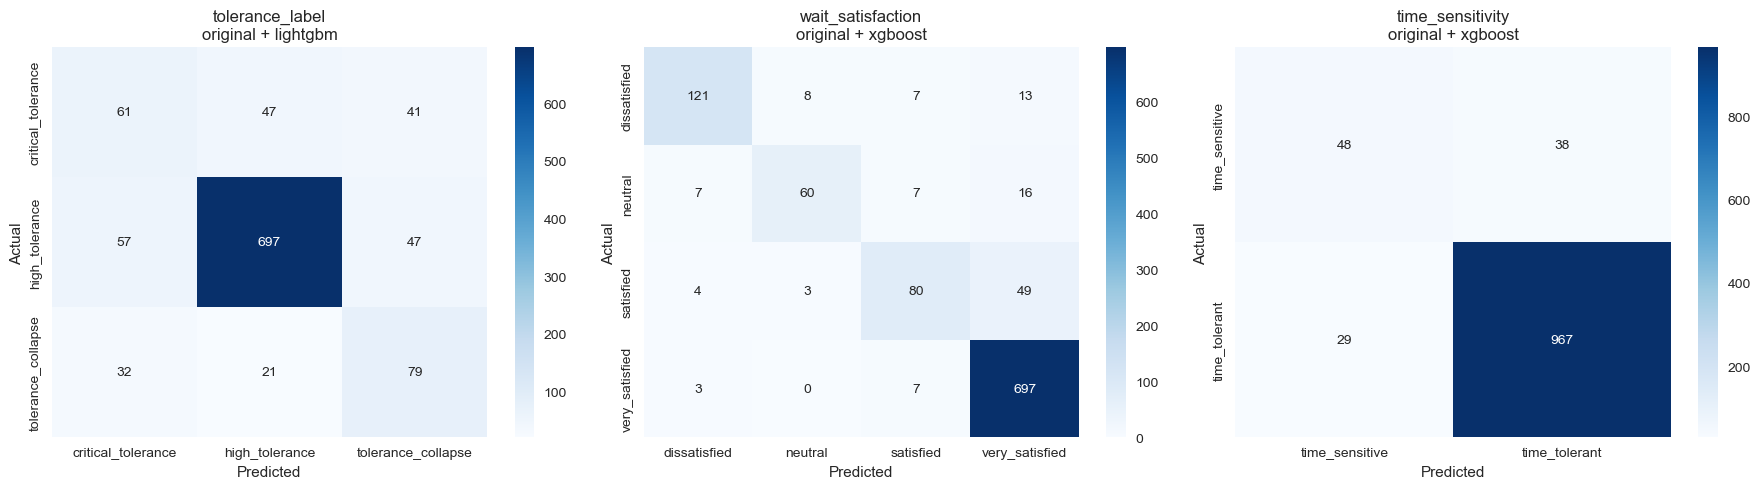


=== DETAILED CLASSIFICATION REPORTS ===

TOLERANCE_LABEL - original + lightgbm
------------------------------------------------------------
critical_tolerance   - Precision: 0.407, Recall: 0.409, F1: 0.408
high_tolerance       - Precision: 0.911, Recall: 0.870, F1: 0.890
tolerance_collapse   - Precision: 0.473, Recall: 0.598, F1: 0.528
Overall              - Macro F1: 0.609, Weighted F1: 0.780

WAIT_SATISFACTION - original + xgboost
------------------------------------------------------------
dissatisfied         - Precision: 0.896, Recall: 0.812, F1: 0.852
neutral              - Precision: 0.845, Recall: 0.667, F1: 0.745
satisfied            - Precision: 0.792, Recall: 0.588, F1: 0.675
very_satisfied       - Precision: 0.899, Recall: 0.986, F1: 0.941
Overall              - Macro F1: 0.803, Weighted F1: 0.879

TIME_SENSITIVITY - original + xgboost
------------------------------------------------------------
time_sensitive       - Precision: 0.623, Recall: 0.558, F1: 0.589
time_toleran

In [19]:
# Detailed confusion matrices for classification tasks
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
classification_targets = [target for target, task_type in target_columns.items() if task_type == 'classification']

for i, target in enumerate(classification_targets):
    best_config = best_models[target]
    strategy, model_name = best_config['strategy'], best_config['model']
    
    # Get predictions and true labels
    result = training_results[strategy][target][model_name]
    y_test = result['y_test']
    y_pred = result['predictions']
    
    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=label_encoders[target].classes_,
                yticklabels=label_encoders[target].classes_)
    
    axes[i].set_title(f'{target}\n{strategy} + {model_name}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()

# Print detailed classification reports for best models
print("\n=== DETAILED CLASSIFICATION REPORTS ===")
for target in classification_targets:
    best_config = best_models[target]
    strategy, model_name = best_config['strategy'], best_config['model']
    
    metrics = evaluation_results[strategy][target][model_name]
    class_report = metrics['classification_report']
    
    print(f"\n{target.upper()} - {strategy} + {model_name}")
    print("-" * 60)
    
    # Print per-class metrics
    for class_name, class_metrics in class_report.items():
        if class_name not in ['accuracy', 'macro avg', 'weighted avg']:
            original_class = label_encoders[target].classes_[int(class_name)] if class_name.isdigit() else class_name
            print(f"{original_class:<20} - Precision: {class_metrics['precision']:.3f}, "
                  f"Recall: {class_metrics['recall']:.3f}, F1: {class_metrics['f1-score']:.3f}")
    
    print(f"{'Overall':<20} - Macro F1: {class_report['macro avg']['f1-score']:.3f}, "
          f"Weighted F1: {class_report['weighted avg']['f1-score']:.3f}")

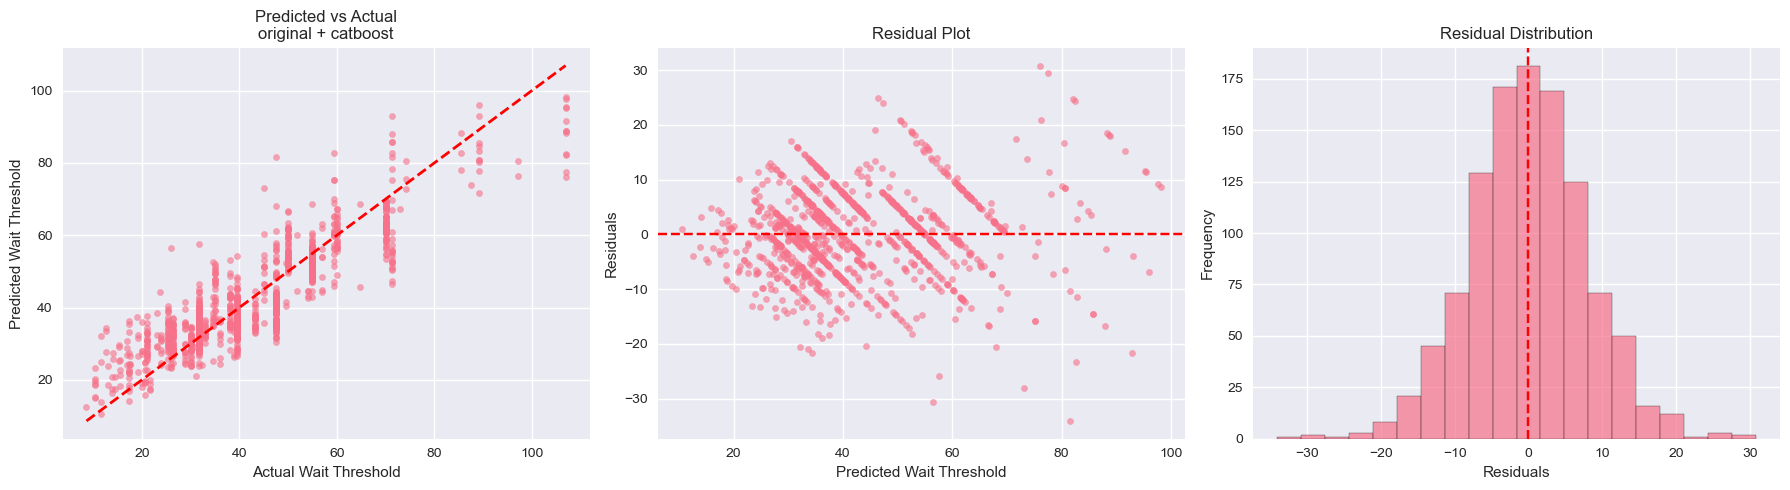


=== REGRESSION PERFORMANCE - WAIT_THRESHOLD ===
Model: original + catboost
R² Score: 0.785
RMSE: 7.97 minutes
MAE: 6.22 minutes
MAPE: 17.3%

Actual range: [8.6, 106.9] minutes
Predicted range: [10.5, 98.2] minutes


In [20]:
# Regression analysis for wait_threshold
target = 'wait_threshold'
best_config = best_models[target]
strategy, model_name = best_config['strategy'], best_config['model']

result = training_results[strategy][target][model_name]
y_test = result['y_test']
y_pred = result['predictions']

# Create regression analysis plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Scatter plot: Predicted vs Actual
axes[0].scatter(y_test, y_pred, alpha=0.6, s=20)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Wait Threshold')
axes[0].set_ylabel('Predicted Wait Threshold')
axes[0].set_title(f'Predicted vs Actual\n{strategy} + {model_name}')

# Residual plot
residuals = y_test - y_pred
axes[1].scatter(y_pred, residuals, alpha=0.6, s=20)
axes[1].axhline(y=0, color='r', linestyle='--')
axes[1].set_xlabel('Predicted Wait Threshold')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Residual Plot')

# Residual distribution
axes[2].hist(residuals, bins=20, alpha=0.7, edgecolor='black')
axes[2].axvline(x=0, color='r', linestyle='--')
axes[2].set_xlabel('Residuals')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Residual Distribution')

plt.tight_layout()
plt.show()

# Print regression metrics
metrics = evaluation_results[strategy][target][model_name]
print(f"\n=== REGRESSION PERFORMANCE - {target.upper()} ===")
print(f"Model: {strategy} + {model_name}")
print(f"R² Score: {metrics['r2']:.3f}")
print(f"RMSE: {metrics['rmse']:.2f} minutes")
print(f"MAE: {metrics['mae']:.2f} minutes")
print(f"MAPE: {metrics['mape']:.1f}%")
print(f"\nActual range: [{y_test.min():.1f}, {y_test.max():.1f}] minutes")
print(f"Predicted range: [{y_pred.min():.1f}, {y_pred.max():.1f}] minutes")

## 9. Feature Importance Analysis

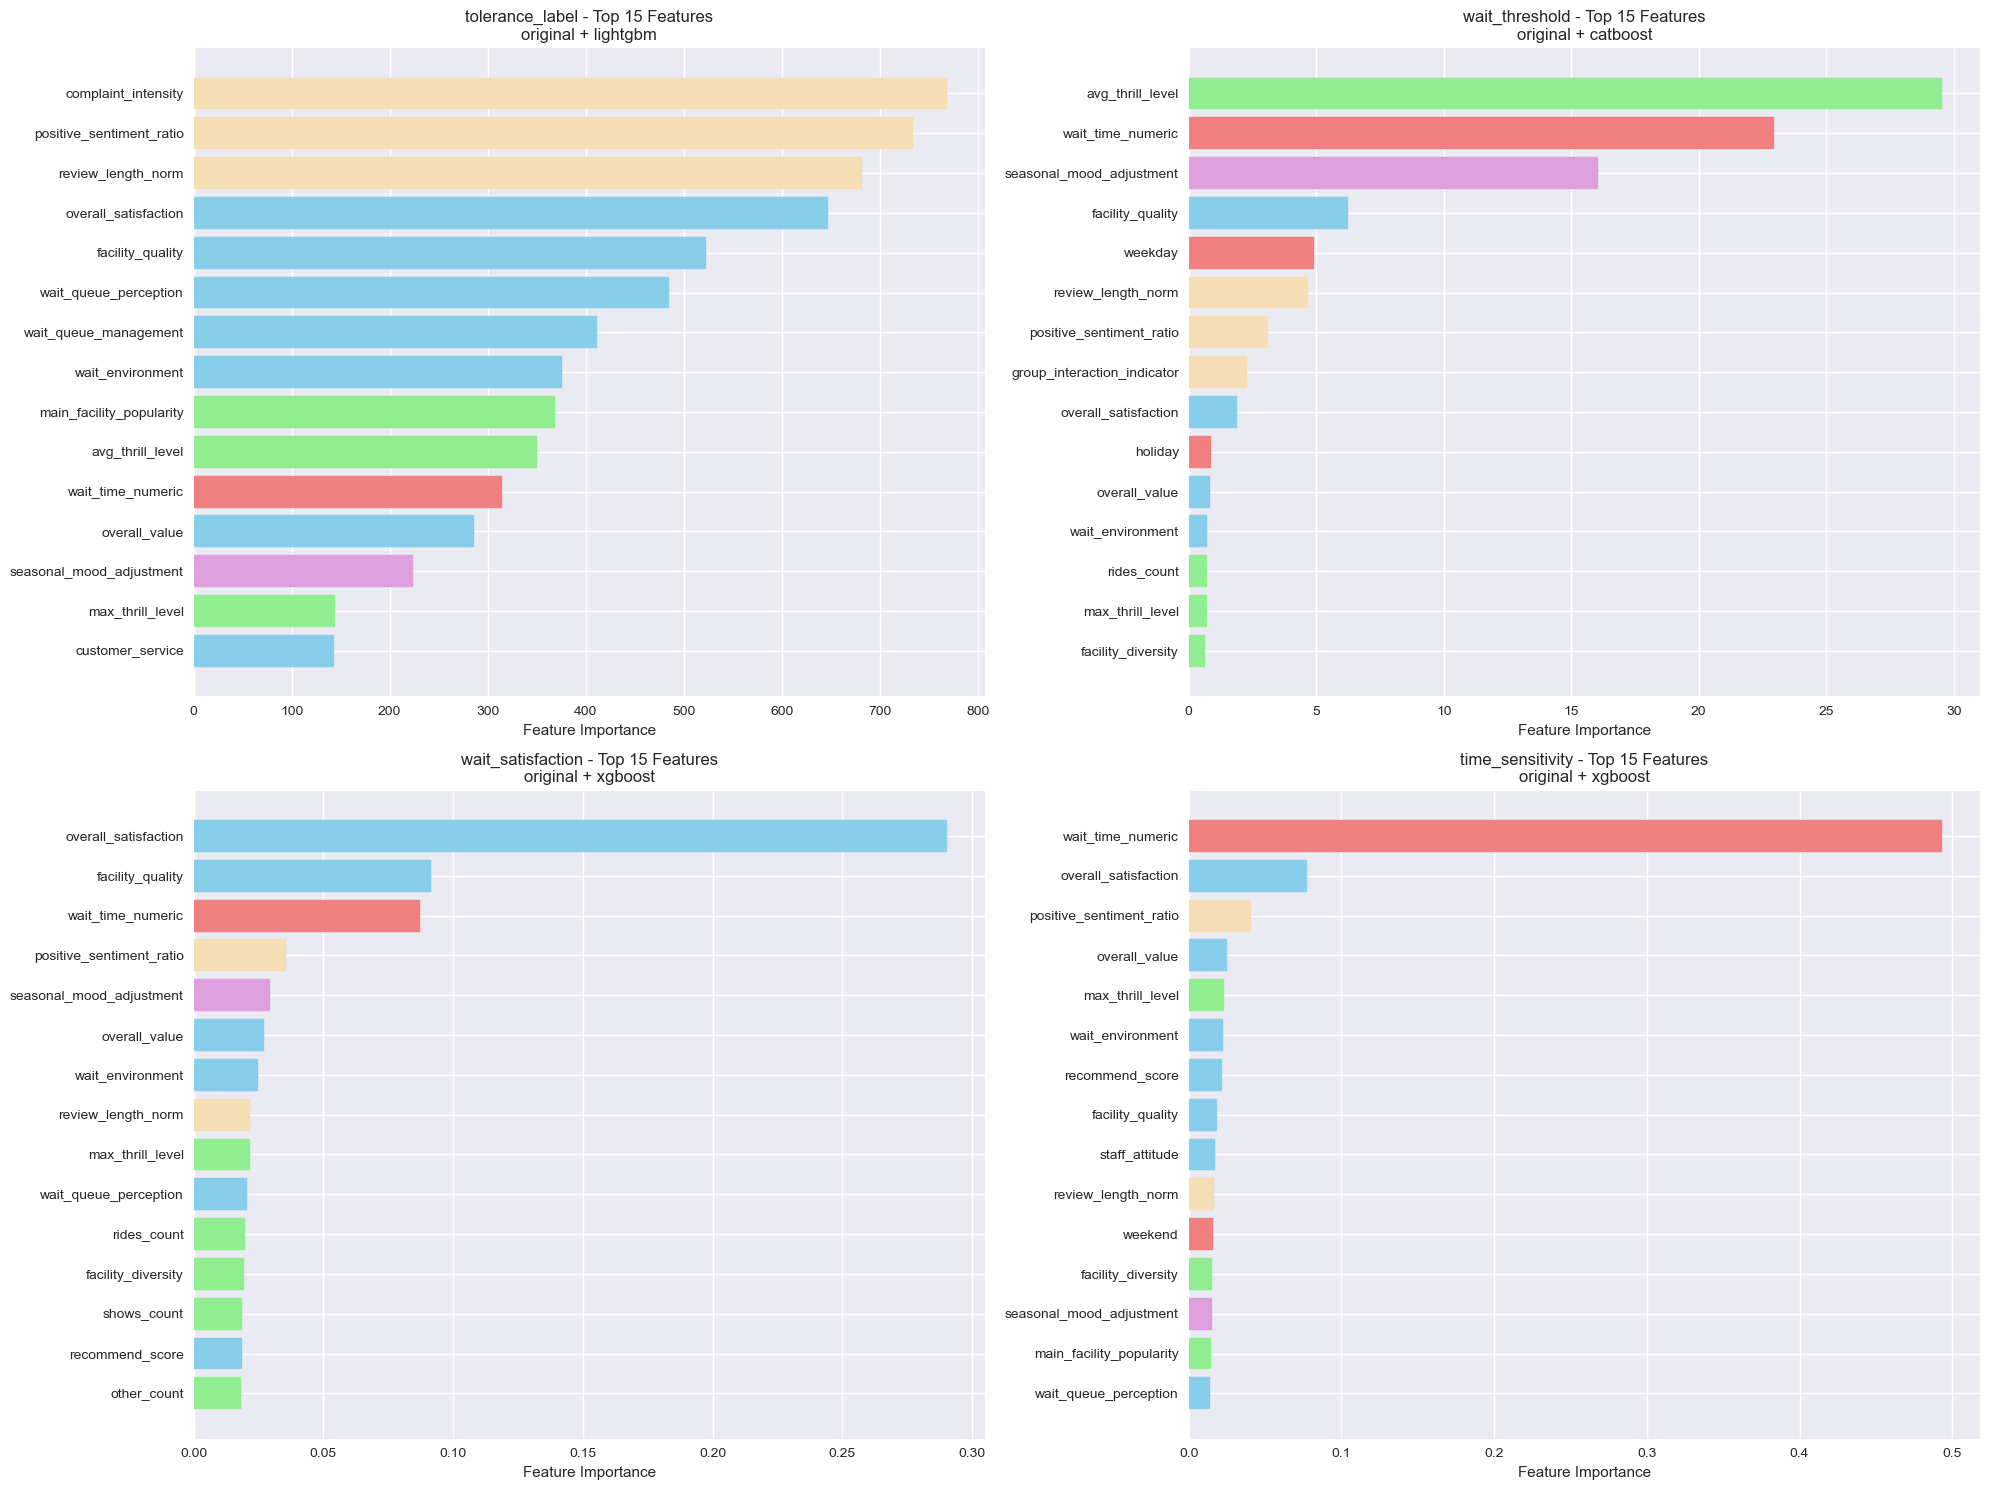

=== FEATURE IMPORTANCE ANALYSIS ===

TOLERANCE_LABEL - Top 10 Most Important Features:
------------------------------------------------------------
complaint_intensity           : 769.0000
positive_sentiment_ratio      : 734.0000
review_length_norm            : 682.0000
overall_satisfaction          : 647.0000
facility_quality              : 523.0000
wait_queue_perception         : 485.0000
wait_queue_management         : 412.0000
wait_environment              : 376.0000
main_facility_popularity      : 369.0000
avg_thrill_level              : 350.0000

Feature Group Average Importance:
User Behavior (5D)       : 459.2000
Sentiment (12D)          : 256.7500
Facility (8D)            : 151.8750
Time Sensitivity (2D)    : 126.0000
Temporal (5D)            : 99.0000

WAIT_THRESHOLD - Top 10 Most Important Features:
------------------------------------------------------------
avg_thrill_level              : 29.5488
wait_time_numeric             : 22.9577
seasonal_mood_adjustment      : 16.05

In [21]:
# Feature importance analysis for best models
def get_feature_importance(model, feature_names, model_type='tree'):
    """
    Extract feature importance from different model types
    """
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importance = np.abs(model.coef_).flatten()
    else:
        return None
    
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    }).sort_values('importance', ascending=False)
    
    return feature_importance_df

# Analyze feature importance for each task
feature_importance_results = {}

fig, axes = plt.subplots(2, 2, figsize=(20, 15))
axes = axes.ravel()

for i, (target, task_type) in enumerate(target_columns.items()):
    best_config = best_models[target]
    strategy, model_name = best_config['strategy'], best_config['model']
    
    # Get the best model
    best_model = training_results[strategy][target][model_name]['model']
    
    # Extract feature importance
    feature_imp_df = get_feature_importance(best_model, feature_columns)
    
    if feature_imp_df is not None:
        feature_importance_results[target] = feature_imp_df
        
        # Plot top 15 features
        top_features = feature_imp_df.head(15)
        
        bars = axes[i].barh(range(len(top_features)), top_features['importance'])
        axes[i].set_yticks(range(len(top_features)))
        axes[i].set_yticklabels(top_features['feature'])
        axes[i].set_xlabel('Feature Importance')
        axes[i].set_title(f'{target} - Top 15 Features\n{strategy} + {model_name}')
        axes[i].invert_yaxis()
        
        # Color bars by feature group
        colors = ['skyblue', 'lightcoral', 'lightgreen', 'wheat', 'plum']
        feature_groups_ranges = [(0, 12), (12, 17), (17, 25), (25, 30), (30, 32)]
        
        for j, (bar, feature_name) in enumerate(zip(bars, top_features['feature'])):
            feature_idx = feature_columns.index(feature_name)
            for k, (start, end) in enumerate(feature_groups_ranges):
                if start <= feature_idx < end:
                    bar.set_color(colors[k])
                    break

plt.tight_layout()
plt.show()

# Print detailed feature importance
print("=== FEATURE IMPORTANCE ANALYSIS ===")
for target in target_columns.keys():
    if target in feature_importance_results:
        print(f"\n{target.upper()} - Top 10 Most Important Features:")
        print("-" * 60)
        
        top_10 = feature_importance_results[target].head(10)
        for idx, row in top_10.iterrows():
            print(f"{row['feature']:<30}: {row['importance']:.4f}")
        
        # Feature group analysis
        feature_group_importance = {}
        groups = {
            'Sentiment (12D)': feature_columns[:12],
            'Temporal (5D)': feature_columns[12:17],
            'Facility (8D)': feature_columns[17:25],
            'User Behavior (5D)': feature_columns[25:30],
            'Time Sensitivity (2D)': feature_columns[30:32]
        }
        
        for group_name, group_features in groups.items():
            group_imp = feature_importance_results[target]
            group_imp = group_imp[group_imp['feature'].isin(group_features)]
            avg_importance = group_imp['importance'].mean()
            feature_group_importance[group_name] = avg_importance
        
        print(f"\nFeature Group Average Importance:")
        for group, avg_imp in sorted(feature_group_importance.items(), key=lambda x: x[1], reverse=True):
            print(f"{group:<25}: {avg_imp:.4f}")

## 10. Model Interpretation with SHAP

=== SHAP ANALYSIS for TOLERANCE_LABEL ===
Best model: original + lightgbm


<Figure size 1200x800 with 0 Axes>

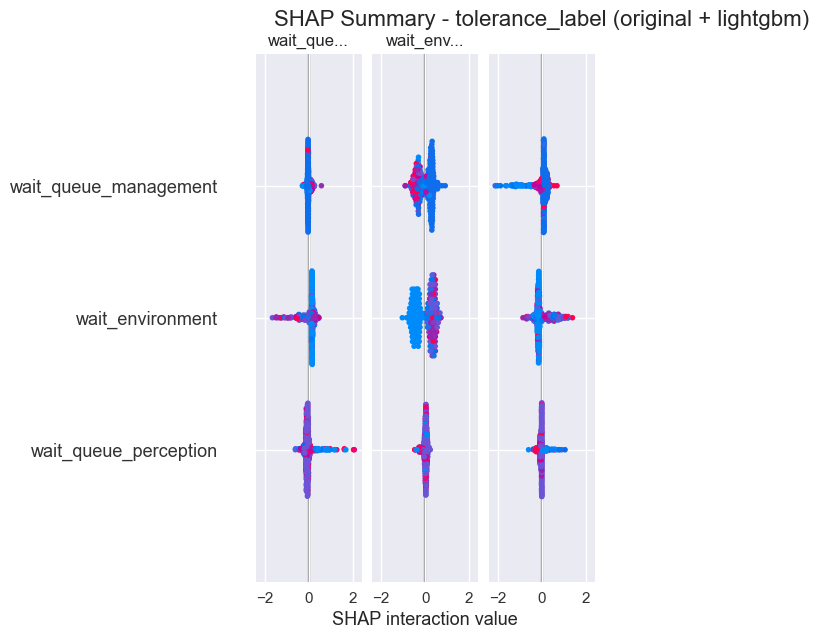


=== FEATURE IMPORTANCE RANKING ===
✗ SHAP analysis failed: Per-column arrays must each be 1-dimensional
This is often due to model compatibility or memory constraints


In [27]:
# SHAP analysis for the main task (tolerance_label)
main_target = 'tolerance_label'
best_config = best_models[main_target]
strategy, model_name = best_config['strategy'], best_config['model']

print(f"=== SHAP ANALYSIS for {main_target.upper()} ===")
print(f"Best model: {strategy} + {model_name}")

try:
    # Get the best model and data
    best_model = training_results[strategy][main_target][model_name]['model']
    X_train_best = resampled_data[strategy]['X_train']
    X_test = splits['X_test']
    
    # Create SHAP explainer
    if model_name in ['lightgbm', 'xgboost', 'catboost', 'random_forest']:
        explainer = shap.TreeExplainer(best_model)
        shap_values = explainer.shap_values(X_test.iloc[:500])  # Use subset for speed
        
        # For multi-class, shap_values is a list
        if isinstance(shap_values, list):
            # 1. IMPROVED Summary plot for all classes with proper legend
            plt.figure(figsize=(18, 12))  # Even larger figure for better readability
            
            # Create the plot with proper parameters
            shap.summary_plot(shap_values, X_test.iloc[:500], 
                            class_names=label_encoders[main_target].classes_,
                            show=False,
                            max_display=15,  # Show more features
                            color_bar=True)  # Ensure color bar is shown
            
            plt.title(f'SHAP Summary Plot - {main_target} ({strategy} + {model_name})', 
                     fontsize=18, pad=25)
            
            # Adjust layout to prevent label cutoff and ensure legend visibility
            plt.subplots_adjust(left=0.2, right=0.85, top=0.9, bottom=0.1)
            
            # Add class labels manually if they're not showing
            class_names = label_encoders[main_target].classes_
            ax = plt.gca()
            
            # Get the subplot positions to add class labels
            if len(class_names) == 3:  # Assuming 3 classes based on your image
                x_positions = [-1.8, 0, 1.8]  # Approximate positions for 3 subplots
                for i, class_name in enumerate(class_names):
                    if i < len(x_positions):
                        ax.text(x_positions[i], ax.get_ylim()[1] + 0.3, f'Class: {class_name}', 
                               ha='center', va='bottom', fontsize=12, fontweight='bold')
            
            plt.show()
            
            # 2. IMPROVED Bar plot for feature importance
            plt.figure(figsize=(16, 8))
            shap.summary_plot(shap_values, X_test.iloc[:500], 
                            plot_type="bar",
                            class_names=label_encoders[main_target].classes_,
                            show=False,
                            max_display=15)
            
            plt.title(f'SHAP Feature Importance - {main_target}', 
                     fontsize=16, pad=20)
            plt.subplots_adjust(left=0.2, right=0.95, top=0.9, bottom=0.1)
            plt.show()
            
            # 3. ADDITIONAL: Individual class plots for better readability
            class_names = label_encoders[main_target].classes_
            for i, class_name in enumerate(class_names):
                plt.figure(figsize=(12, 6))
                shap.summary_plot(shap_values[i], X_test.iloc[:500], 
                                show=False,
                                max_display=10)
                plt.title(f'SHAP Analysis - {main_target} (Class: {class_name})', 
                         fontsize=14, pad=20)
                plt.subplots_adjust(left=0.3, right=0.95, top=0.9, bottom=0.1)
                plt.show()
                
        else:
            # Binary classification
            plt.figure(figsize=(12, 8))
            shap.summary_plot(shap_values, X_test.iloc[:500], show=False)
            plt.title(f'SHAP Summary - {main_target} ({strategy} + {model_name})', 
                     fontsize=16, pad=20)
            plt.subplots_adjust(left=0.25, right=0.95, top=0.9, bottom=0.1)
            plt.show()
    
    # 4. ADDITIONAL: Feature importance ranking
    print("\n=== FEATURE IMPORTANCE RANKING ===")
    if isinstance(shap_values, list):
        # For multi-class, calculate mean absolute SHAP values across all classes
        import numpy as np
        feature_importance = np.mean([np.abs(sv).mean(0) for sv in shap_values], axis=0)
    else:
        feature_importance = np.abs(shap_values).mean(0)
    
    feature_names = X_test.columns
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
    print(importance_df.to_string(index=False))
    
    print("✓ SHAP analysis completed successfully")
    
except Exception as e:
    print(f"✗ SHAP analysis failed: {e}")
    print("This is often due to model compatibility or memory constraints")

## 11. Results Summary and Model Recommendations

In [23]:
# Create final comprehensive summary
print("=" * 80)
print("                    FINAL RESULTS SUMMARY                    ")
print("=" * 80)

print("\n📊 DATASET OVERVIEW:")
print(f"• Total samples: {len(data):,}")
print(f"• Feature dimensions: {len(feature_columns)}D")
print(f"• Training set: {len(splits['X_train']):,} samples")
print(f"• Test set: {len(splits['X_test']):,} samples")

print("\n🎯 PREDICTION TASKS:")
for target, task_type in target_columns.items():
    print(f"• {target}: {task_type}")

print("\n⚖️ IMBALANCE HANDLING:")
print(f"• Resampling strategies tested: {list(resampling_strategies.keys())}")
print(f"• Models tested per task: {len(classification_models)} (classification), {len(regression_models)} (regression)")

print("\n🏆 BEST MODEL PERFORMANCE:")
for target, config in best_models.items():
    task_type = target_columns[target]
    metrics = evaluation_results[config['strategy']][target][config['model']]
    
    print(f"\n• {target.upper()} ({task_type}):")
    print(f"  Model: {config['strategy']} + {config['model']}")
    
    if task_type == 'classification':
        print(f"  Performance: F1-Macro={metrics['f1_macro']:.3f}, Accuracy={metrics['accuracy']:.3f}")
        
        # Class-specific performance
        class_report = metrics['classification_report']
        print(f"  Class Performance:")
        for class_name, class_metrics in class_report.items():
            if class_name not in ['accuracy', 'macro avg', 'weighted avg']:
                if class_name.isdigit():
                    original_class = label_encoders[target].classes_[int(class_name)]
                    print(f"    {original_class}: F1={class_metrics['f1-score']:.3f}, Recall={class_metrics['recall']:.3f}")
    else:
        print(f"  Performance: R²={metrics['r2']:.3f}, RMSE={metrics['rmse']:.2f}, MAE={metrics['mae']:.2f}")

print("\n🔍 KEY INSIGHTS:")

# Analyze which resampling strategy works best
strategy_performance = {}
for strategy in resampling_strategies.keys():
    strategy_scores = []
    for target, task_type in target_columns.items():
        for model_name in evaluation_results[strategy][target].keys():
            metrics = evaluation_results[strategy][target][model_name]
            if task_type == 'classification':
                strategy_scores.append(metrics['f1_macro'])
            else:
                strategy_scores.append(metrics['r2'])
    strategy_performance[strategy] = np.mean(strategy_scores)

best_strategy = max(strategy_performance, key=strategy_performance.get)
print(f"• Best overall resampling strategy: {best_strategy} (avg score: {strategy_performance[best_strategy]:.3f})")

# Analyze which model type works best
model_performance = {}
all_models = set(list(classification_models.keys()) + list(regression_models.keys()))
for model_name in all_models:
    model_scores = []
    for strategy in resampling_strategies.keys():
        for target, task_type in target_columns.items():
            if model_name in evaluation_results[strategy][target]:
                metrics = evaluation_results[strategy][target][model_name]
                if task_type == 'classification':
                    model_scores.append(metrics['f1_macro'])
                else:
                    model_scores.append(metrics['r2'])
    if model_scores:
        model_performance[model_name] = np.mean(model_scores)

best_model_type = max(model_performance, key=model_performance.get)
print(f"• Best overall model type: {best_model_type} (avg score: {model_performance[best_model_type]:.3f})")

# Feature group importance analysis
if feature_importance_results:
    print(f"\n• Most important feature groups across all tasks:")
    
    group_names = ['Sentiment', 'Temporal', 'Facility', 'User Behavior', 'Time Sensitivity']
    group_ranges = [(0, 12), (12, 17), (17, 25), (25, 30), (30, 32)]
    
    overall_group_importance = {}
    for group_name, (start, end) in zip(group_names, group_ranges):
        group_features = feature_columns[start:end]
        group_scores = []
        
        for target in feature_importance_results.keys():
            feature_imp_df = feature_importance_results[target]
            group_imp = feature_imp_df[feature_imp_df['feature'].isin(group_features)]
            if not group_imp.empty:
                group_scores.append(group_imp['importance'].mean())
        
        if group_scores:
            overall_group_importance[group_name] = np.mean(group_scores)
    
    for group, importance in sorted(overall_group_importance.items(), key=lambda x: x[1], reverse=True):
        print(f"    {group}: {importance:.4f}")


                    FINAL RESULTS SUMMARY                    

📊 DATASET OVERVIEW:
• Total samples: 5,409
• Feature dimensions: 32D
• Training set: 4,327 samples
• Test set: 1,082 samples

🎯 PREDICTION TASKS:
• tolerance_label: classification
• wait_threshold: regression
• wait_satisfaction: classification
• time_sensitivity: classification

⚖️ IMBALANCE HANDLING:
• Resampling strategies tested: ['original', 'smote', 'adasyn', 'smote_enn']
• Models tested per task: 4 (classification), 4 (regression)

🏆 BEST MODEL PERFORMANCE:

• TOLERANCE_LABEL (classification):
  Model: original + lightgbm
  Performance: F1-Macro=0.609, Accuracy=0.774
  Class Performance:

• WAIT_THRESHOLD (regression):
  Model: original + catboost
  Performance: R²=0.785, RMSE=7.97, MAE=6.22

• WAIT_SATISFACTION (classification):
  Model: original + xgboost
  Performance: F1-Macro=0.803, Accuracy=0.885
  Class Performance:

• TIME_SENSITIVITY (classification):
  Model: original + xgboost
  Performance: F1-Macro=0.778

## 12. Model Persistence and Export

In [24]:
import joblib
import os

# Create directory for model artifacts
model_dir = 'output/models/queue-tolerance-prediction/baseline_models'
os.makedirs(model_dir, exist_ok=True)

# Save best models and preprocessing components
artifacts_to_save = {
    'scaler': scaler,
    'label_encoders': label_encoders,
    'feature_columns': feature_columns,
    'target_columns': target_columns,
    'best_models_config': best_models
}

# Save preprocessing artifacts
for artifact_name, artifact in artifacts_to_save.items():
    joblib.dump(artifact, os.path.join(model_dir, f'{artifact_name}.pkl'))
    print(f"✓ Saved {artifact_name}")

# Save best models
for target, config in best_models.items():
    strategy, model_name = config['strategy'], config['model']
    best_model = training_results[strategy][target][model_name]['model']
    
    model_filename = f'best_{target}_{strategy}_{model_name}.pkl'
    joblib.dump(best_model, os.path.join(model_dir, model_filename))
    print(f"✓ Saved best model for {target}: {model_filename}")

# Save evaluation results
joblib.dump(evaluation_results, os.path.join(model_dir, 'evaluation_results.pkl'))
joblib.dump(performance_summaries, os.path.join(model_dir, 'performance_summaries.pkl'))

# Export performance summary to CSV
for target, summary_df in performance_summaries.items():
    summary_df.to_csv(os.path.join(model_dir, f'performance_summary_{target}.csv'), index=False)

print(f"\n=== Model artifacts saved to {model_dir} ===")
print(f"• Preprocessing components: scaler, label encoders, feature definitions")
print(f"• Best models: {len(best_models)} trained models")
print(f"• Evaluation results: comprehensive performance metrics")
print(f"• Performance summaries: CSV files for easy analysis")

✓ Saved scaler
✓ Saved label_encoders
✓ Saved feature_columns
✓ Saved target_columns
✓ Saved best_models_config
✓ Saved best model for tolerance_label: best_tolerance_label_original_lightgbm.pkl
✓ Saved best model for wait_threshold: best_wait_threshold_original_catboost.pkl
✓ Saved best model for wait_satisfaction: best_wait_satisfaction_original_xgboost.pkl
✓ Saved best model for time_sensitivity: best_time_sensitivity_original_xgboost.pkl

=== Model artifacts saved to output/models/queue-tolerance-prediction/baseline_models ===
• Preprocessing components: scaler, label encoders, feature definitions
• Best models: 4 trained models
• Evaluation results: comprehensive performance metrics
• Performance summaries: CSV files for easy analysis
